<a href="https://colab.research.google.com/github/timothylabounko/Burbank-Bike-Safety-Score-Calculator/blob/main/Burbank_Streets_Final_8_29_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx
!pip install momepy
!pip install shapely

In [2]:
import osmnx as ox
import numpy as pd
import geopandas as gpd
import pandas as pd
import fiona as fio
import os
import math
import networkx as nx
import numpy as np
from shapely.geometry import Point, LineString
import shapely
import shapely.geometry as sg

In [3]:
G = ox.graph_from_place('Burbank, CA, USA', network_type='drive')

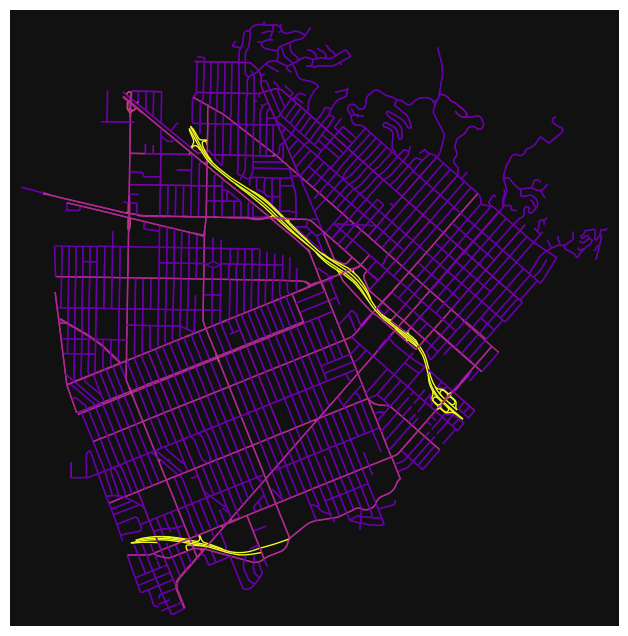

In [4]:
G = ox.add_edge_speeds(G)
ec = ox.plot.get_edge_colors_by_attr(G, 'speed_kph', cmap='plasma')

fig, ax = ox.plot_graph(G, node_size=0, edge_color = ec)

In [5]:
nodes, edges = ox.graph_to_gdfs(G, edges=True, nodes=True)

In [6]:
edges.head()

osmid  \
u        v         key                                                      
10537785 26740011  0    [1049263106, 608855534, 31973422, 31973427, 31...   
10537865 122730799 0                               [402510945, 402510964]   
         14940484  0                    [402510995, 402510980, 402510940]   
         26959286  0                                            723757864   
         21490272  0                                            723757864   

                        oneway lanes  ref                      name  \
u        v         key                                                
10537785 26740011  0      True     6  I 5      Golden State Freeway   
10537865 122730799 0     False     5  NaN  North Glenoaks Boulevard   
         14940484  0     False     4  NaN  North Glenoaks Boulevard   
         26959286  0     False   NaN  NaN             Amherst Drive   
         21490272  0     False   NaN  NaN             Amherst Drive   

                            highway maxspeed reversed   length bridge  \
u        v         key                                                  
10537785 26740011  0       motorway   65 mph    False  445.063    yes   
10537865 122730799 0      secondary      NaN     True  101.895    NaN   
         14940484  0      secondary      NaN    False  111.912    NaN   
         26959286  0    residential      NaN    False  168.947    NaN   
         21490272  0    residential      NaN     True  176.387    NaN   

                                                                 geometry  \
u        v         key                                                      
10537785 26740011  0    LINESTRING (-118.30621 34.17323, -118.30628 34...   
10537865 122730799 0    LINESTRING (-118.31868 34.19228, -118.31900 34...   
         14940484  0    LINESTRING (-118.31868 34.19228, -118.31839 34...   
         26959286  0    LINESTRING (-118.31868 34.19228, -118.31831 34...   
         21490272  0    LINESTRING (-118.31868 34.19228, -118.31901 34...   

                        speed_kph tunnel width  
u        v         key                          
10537785 26740011  0        104.6    NaN   NaN  
10537865 122730799 0         55.7    NaN   NaN  
         14940484  0         55.7    NaN   NaN  
         26959286  0         39.7    NaN   NaN  
         21490272  0         39.7    NaN   NaN

In [7]:
# Accident Data points for research lab at UC Berkeley.
# Before 2022 the data is inaccurate, data is collected from Jan of 2022 to Mar 2024.
TIMS_data = pd.read_csv("/content/sample_data/Crashes-Updated.csv")

In [8]:
TIMS_data.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,82186492,2022,2023-10-02,1912,2022-10-16,1751,15509,NaN,7,5,...,0,0,-,-,34.170559,-118.315041,LOS ANGELES,BURBANK,-118.315079,34.170570
1,82186497,2022,2023-10-02,1912,2022-01-12,1910,15454,NaN,3,5,...,0,0,-,-,34.184731,-118.349159,LOS ANGELES,BURBANK,-118.349159,34.184803
2,82186499,2022,2023-10-02,1912,2022-01-04,1205,9542,NaN,2,5,...,0,0,-,-,34.156502,-118.334419,LOS ANGELES,BURBANK,-118.334389,34.156528
3,82186500,2022,2023-10-02,1912,2022-01-04,1231,11832,NaN,2,5,...,0,0,-,-,NaN,NaN,LOS ANGELES,BURBANK,NaN,NaN
4,82186503,2022,2023-10-02,1912,2022-02-03,1205,13377,NaN,4,5,...,0,0,-,-,NaN,NaN,LOS ANGELES,BURBANK,-118.339790,34.153004


In [9]:
TIMS_points = gpd.GeoDataFrame(TIMS_data, crs="EPSG:4326", geometry=gpd.points_from_xy(TIMS_data.POINT_X, TIMS_data.POINT_Y))

In [10]:
TIMS_points.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,geometry
0,82186492,2022,2023-10-02,1912,2022-10-16,1751,15509,NaN,7,5,...,0,-,-,34.170559,-118.315041,LOS ANGELES,BURBANK,-118.315079,34.170570,POINT (-118.31508 34.17057)
1,82186497,2022,2023-10-02,1912,2022-01-12,1910,15454,NaN,3,5,...,0,-,-,34.184731,-118.349159,LOS ANGELES,BURBANK,-118.349159,34.184803,POINT (-118.34916 34.18480)
2,82186499,2022,2023-10-02,1912,2022-01-04,1205,9542,NaN,2,5,...,0,-,-,34.156502,-118.334419,LOS ANGELES,BURBANK,-118.334389,34.156528,POINT (-118.33439 34.15653)
3,82186500,2022,2023-10-02,1912,2022-01-04,1231,11832,NaN,2,5,...,0,-,-,NaN,NaN,LOS ANGELES,BURBANK,NaN,NaN,POINT EMPTY
4,82186503,2022,2023-10-02,1912,2022-02-03,1205,13377,NaN,4,5,...,0,-,-,NaN,NaN,LOS ANGELES,BURBANK,-118.339790,34.153004,POINT (-118.33979 34.15300)


In [11]:
# Drop uneccesary columns from geodataframe.
TIMS_points = TIMS_points.drop(columns=['PROC_DATE',
                                        'JURIS',
                                        'COLLISION_DATE',
                                        'COLLISION_TIME',
                                        'OFFICER_ID',
                                        'REPORTING_DISTRICT',
                                        'DAY_OF_WEEK',
                                        'CHP_SHIFT',
                                        'POPULATION',
                                        'CNTY_CITY_LOC',
                                        'SPECIAL_COND',
                                        'BEAT_TYPE',
                                        'CHP_BEAT_TYPE',
                                        'CITY_DIVISION_LAPD',
                                        'CHP_BEAT_CLASS',
                                        'BEAT_NUMBER',
                                        'CALTRANS_COUNTY',
                                        'CALTRANS_DISTRICT',
                                        'STATE_ROUTE',
                                        'ROUTE_SUFFIX',
                                        'POSTMILE_PREFIX',
                                        'POSTMILE',
                                        'LOCATION_TYPE',
                                        'RAMP_INTERSECTION',
                                        'SIDE_OF_HWY',
                                        'TOW_AWAY',
                                        'COLLISION_SEVERITY',
                                        'PARTY_COUNT',
                                        'PRIMARY_COLL_FACTOR',
                                        'PCF_CODE_OF_VIOL',
                                        'PCF_VIOL_CATEGORY',
                                        'PCF_VIOLATION',
                                        'PCF_VIOL_SUBSECTION',
                                        'HIT_AND_RUN',
                                        'TYPE_OF_COLLISION',
                                        'MVIW', 'PED_ACTION',
                                        'ROAD_SURFACE',
                                        'ROAD_COND_1',
                                        'ROAD_COND_2',
                                        'LIGHTING',
                                        'CONTROL_DEVICE',
                                        'CHP_ROAD_TYPE',
                                        'MOTORCYCLE_ACCIDENT',
                                        'TRUCK_ACCIDENT',
                                        'NOT_PRIVATE_PROPERTY',
                                        'ALCOHOL_INVOLVED',
                                        'STWD_VEHTYPE_AT_FAULT',
                                        'CHP_VEHTYPE_AT_FAULT',
                                        'PRIMARY_RAMP',
                                        'SECONDARY_RAMP'])

In [12]:
gdf_cycleways = gpd.read_file("/content/sample_data/Bike_Routes_%E2%80%93_SCAG_Region.zip", geometry="geometry")
gdf_cycleways.head()

,OBJECTID,NAME,CITY,COUNTY,CLASS_E,FACDES_E,CLASS_P,FACDES_P,INSTALL_DA,MILES_1,...,APP_ID,FTIP_ID,RBN,NOTES,YEAR,BIKEDIR,LANECOUNT,PLAN_NAME,Shapelen,geometry
0,1,Grand Ave,Diamond Bar,Los Angeles County,2,None,0,None,None,0.00173,...,0,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,2.795049,"LINESTRING (-117.79115 33.99470, -117.79112 33..."
1,2,Hellman Ave,Eastvale,Riverside County,0,None,1,None,None,1.01910,...,0,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,1640.092825,"MULTILINESTRING ((-117.61100 33.96526, -117.61..."
2,3,Hellman Ave,Eastvale,Riverside County,0,None,2,None,None,1.24939,...,0,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,2010.700514,"MULTILINESTRING ((-117.61092 33.94943, -117.61..."
3,4,Sierra Ave,Jurupa Valley,Riverside County,0,None,2,None,None,0.02935,...,0,0,None,Added based on local input (City of Fontana),2019,None,0,San Bernardino County Non-Motorized Transporta...,47.236466,"LINESTRING (-117.43325 34.03418, -117.43300 34..."
4,5,Cactus Ave,Jurupa Valley,Riverside County,0,None,2,None,None,0.01826,...,0,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,29.401198,"LINESTRING (-117.38328 34.03411, -117.38328 34..."


In [13]:
for col in gdf_cycleways.columns:
  print(col)

OBJECTID
NAME
CITY
COUNTY
CLASS_E
FACDES_E
CLASS_P
FACDES_P
INSTALL_DA
MILES_1
ON_
FROM_
TO_
PLAN_ADOP
PLAN_JURIS
PLAN_URL
APP_ID
FTIP_ID
RBN
NOTES
YEAR
BIKEDIR
LANECOUNT
PLAN_NAME
Shapelen
geometry


In [14]:
# So that we know how to append nodes in the Burbank Street Network to the cycleways in the SCAG shapefile.
nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
10537785,34.173225,-118.306211,3,NaN,NaN,POINT (-118.30621 34.17323)
10537865,34.192284,-118.318677,4,traffic_signals,NaN,POINT (-118.31868 34.19228)
10537871,34.181023,-118.303244,4,traffic_signals,NaN,POINT (-118.30324 34.18102)
14758466,34.184283,-118.321734,6,traffic_signals,NaN,POINT (-118.32173 34.18428)
14758467,34.177441,-118.318401,4,traffic_signals,NaN,POINT (-118.31840 34.17744)


In [15]:
# Create a point column so that we can append the cycleways to the overall edges network.
# Define the function to convert LineString to the first point
def linestring_to_point(line):
    # Handle both LineString and MultiLineString geometries
    if line is not None:
        if line.geom_type == 'LineString':
            first_coordinate = line.coords[0] # Access the coordinates of the LineString
            return Point(first_coordinate)
        elif line.geom_type == 'MultiLineString':
            # Extract the first coordinate of the first LineString in the MultiLineString
            first_line = line.geoms[0]
            first_coordinate = first_line.coords[0] # Access the coordinates of the first LineString
            return Point(first_coordinate)
        else:
            return None
    else:
        return None

# Convert MultiLineStrings to LineStrings
gdf_cycleways['geometry'] = gdf_cycleways['geometry'].apply(lambda geom: geom.geoms[0] if geom is not None and geom.geom_type == 'MultiLineString' else geom)

# Extract the first point of each geometry and store it in a new 'point' column
gdf_cycleways['point'] = gdf_cycleways["geometry"].apply(linestring_to_point)
gdf_cycleways.head()

,OBJECTID,NAME,CITY,COUNTY,CLASS_E,FACDES_E,CLASS_P,FACDES_P,INSTALL_DA,MILES_1,...,FTIP_ID,RBN,NOTES,YEAR,BIKEDIR,LANECOUNT,PLAN_NAME,Shapelen,geometry,point
0,1,Grand Ave,Diamond Bar,Los Angeles County,2,None,0,None,None,0.00173,...,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,2.795049,"LINESTRING (-117.79115 33.99470, -117.79112 33...",POINT (-117.79115 33.99470)
1,2,Hellman Ave,Eastvale,Riverside County,0,None,1,None,None,1.01910,...,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,1640.092825,"LINESTRING (-117.61100 33.96526, -117.61100 33...",POINT (-117.61100 33.96526)
2,3,Hellman Ave,Eastvale,Riverside County,0,None,2,None,None,1.24939,...,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,2010.700514,"LINESTRING (-117.61092 33.94943, -117.61094 33...",POINT (-117.61092 33.94943)
3,4,Sierra Ave,Jurupa Valley,Riverside County,0,None,2,None,None,0.02935,...,0,None,Added based on local input (City of Fontana),2019,None,0,San Bernardino County Non-Motorized Transporta...,47.236466,"LINESTRING (-117.43325 34.03418, -117.43300 34...",POINT (-117.43325 34.03418)
4,5,Cactus Ave,Jurupa Valley,Riverside County,0,None,2,None,None,0.01826,...,0,None,None,2019,None,0,San Bernardino County Non-Motorized Transporta...,29.401198,"LINESTRING (-117.38328 34.03411, -117.38328 34...",POINT (-117.38328 34.03411)


In [16]:
# Anything that is a bikeway the speed limit should be 25 kph
bikeway_edges = gdf_cycleways[(gdf_cycleways['CITY'] == "Burbank")]
bikeway_edges["length"] = bikeway_edges["MILES_1"]*1609.34
bikeway_edges["speed_kph"] = 25.0
bikeway_edges.head()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,OBJECTID,NAME,CITY,COUNTY,CLASS_E,FACDES_E,CLASS_P,FACDES_P,INSTALL_DA,MILES_1,...,NOTES,YEAR,BIKEDIR,LANECOUNT,PLAN_NAME,Shapelen,geometry,point,length,speed_kph
4051,4052,None,Burbank,Los Angeles County,2,None,0,None,6/10/2013,0.38723,...,None,2019,None,0,None,623.188341,"LINESTRING (-118.36216 34.20129, -118.36215 34...",POINT (-118.36216 34.20129),623.184728,25.0
4117,4118,N CALIFORNIA ST,Burbank,Los Angeles County,3,None,0,None,None,0.03813,...,None,2019,None,0,13-Burbank-Bicycle Master Plan-2009,61.375263,"LINESTRING (-118.34269 34.16873, -118.34275 34...",POINT (-118.34269 34.16873),61.364134,25.0
4180,4181,E VERDUGO AV,Burbank,Los Angeles County,2,None,0,None,None,0.41369,...,None,2019,None,0,13-Burbank-Bicycle Master Plan-2009,665.775628,"LINESTRING (-118.30448 34.17988, -118.30442 34...",POINT (-118.30448 34.17988),665.767865,25.0
4211,4212,N 3RD ST,Burbank,Los Angeles County,2,None,0,None,None,0.78937,...,None,2019,None,0,13-Burbank-Bicycle Master Plan-2009,1270.382783,"LINESTRING (-118.30850 34.18281, -118.30857 34...",POINT (-118.30850 34.18281),1270.364716,25.0
4216,4217,N FRONT ST,Burbank,Los Angeles County,2,None,0,None,None,0.62171,...,None,2019,None,0,13-Burbank-Bicycle Master Plan-2009,1000.551244,"LINESTRING (-118.31438 34.18063, -118.31446 34...",POINT (-118.31438 34.18063),1000.542771,25.0


<Axes: >

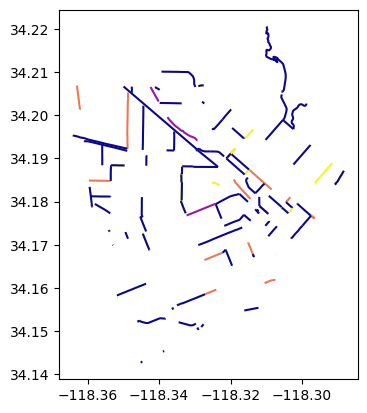

In [17]:
bikeway_edges.plot(column="CLASS_E", cmap='plasma')

In [18]:
# Create a new dataframe with the cycleways points.
bike_dataframe = pd.DataFrame({
    'CLASS_E': bikeway_edges.CLASS_E,
    'speed_kph': bikeway_edges.speed_kph
})

bike_dataframe['geometry'] = bikeway_edges.point

bikeway_points = gpd.GeoDataFrame(bike_dataframe, geometry='geometry')
bikeway_points.head()

,CLASS_E,speed_kph,geometry
4051,2,25.0,POINT (-118.36216 34.20129)
4117,3,25.0,POINT (-118.34269 34.16873)
4180,2,25.0,POINT (-118.30448 34.17988)
4211,2,25.0,POINT (-118.30850 34.18281)
4216,2,25.0,POINT (-118.31438 34.18063)


In [19]:
# Spatially join the traffic accidents points and the bikeways_points data.
# No outer join function, so must do two left joins then concatonate.
left_join_1 = TIMS_points.sjoin(bikeway_points, how="left")
left_join_2 = bikeway_points.sjoin(TIMS_points, how="left", lsuffix='bike', rsuffix='tims')
acc_and_bikeways = pd.concat([left_join_1, left_join_2])

# Remove Duplicates and remove index_right for later spatial join with edges.
acc_and_bikeways = acc_and_bikeways.drop_duplicates()
acc_and_bikeways = acc_and_bikeways.drop(columns=["index_right"])
acc_and_bikeways.head()

,CASE_ID,ACCIDENT_YEAR,PRIMARY_RD,SECONDARY_RD,DISTANCE,DIRECTION,INTERSECTION,WEATHER_1,WEATHER_2,STATE_HWY_IND,...,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,geometry,CLASS_E,speed_kph,index_tims
0,82186492.0,2022.0,VICTORY BOULEVARD,VERDUGO AVENUE,0.0,NaN,Y,A,-,N,...,34.170559,-118.315041,LOS ANGELES,BURBANK,-118.315079,34.170570,POINT (-118.31508 34.17057),NaN,NaN,NaN
1,82186497.0,2022.0,HOLLYWOOD WAY,VICTORY BOULEVARD,30.0,N,N,A,-,N,...,34.184731,-118.349159,LOS ANGELES,BURBANK,-118.349159,34.184803,POINT (-118.34916 34.18480),NaN,NaN,NaN
2,82186499.0,2022.0,OLIVE AVENUE,FAIRVIEW STREET,0.0,NaN,Y,A,-,N,...,34.156502,-118.334419,LOS ANGELES,BURBANK,-118.334389,34.156528,POINT (-118.33439 34.15653),NaN,NaN,NaN
3,82186500.0,2022.0,ALAMEDA AVENUE,GATEWAY,15.0,W,N,A,-,N,...,NaN,NaN,LOS ANGELES,BURBANK,NaN,NaN,POINT EMPTY,NaN,NaN,NaN
4,82186503.0,2022.0,HOLLYWOOD WAY,RIVERSIDE DRIVE,0.0,NaN,Y,A,-,N,...,NaN,NaN,LOS ANGELES,BURBANK,-118.339790,34.153004,POINT (-118.33979 34.15300),NaN,NaN,NaN


In [20]:
# CRS code for LA County
epsg_code = 2229

# Save old edges.
old_edges = edges.copy()

# Reproject the GeoDataFrames to LA County.
edges = edges.to_crs(epsg=epsg_code)
acc_and_bikeways = acc_and_bikeways.to_crs(epsg=epsg_code)

# Create a buffer around the edges with a distance of 10 meters
edges = edges.set_geometry(edges["geometry"].buffer(10))

# Perform the spatial join (using 'intersects' or 'within' might be more appropriate depending on your needs)
projected_edges = edges.sjoin(acc_and_bikeways, how="inner", predicate="intersects")

# Check to see if everything was recorded properly
print(projected_edges.head())

                                                                     osmid  \
u         v         key                                                      
10537785  26740011  0    [1049263106, 608855534, 31973422, 31973427, 31...   
20842254  122855607 0                                            402506314   
122855607 20842254  0                                            402506314   
10537785  26740011  0    [1049263106, 608855534, 31973422, 31973427, 31...   
10537865  122730799 0                               [402510945, 402510964]   

                         oneway lanes  ref                      name  \
u         v         key                                                
10537785  26740011  0      True     6  I 5      Golden State Freeway   
20842254  122855607 0     False   NaN  NaN       South Flower Street   
122855607 20842254  0     False   NaN  NaN       South Flower Street   
10537785  26740011  0      True     6  I 5      Golden State Freeway   
10537865  122730799 0

In [21]:
# Check columns before dropping.
projected_edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'geometry', 'speed_kph_left', 'tunnel',
       'width', 'index_right', 'CASE_ID', 'ACCIDENT_YEAR', 'PRIMARY_RD',
       'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION', 'WEATHER_1',
       'WEATHER_2', 'STATE_HWY_IND', 'NUMBER_KILLED', 'NUMBER_INJURED',
       'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'COUNT_SEVERE_INJ',
       'COUNT_VISIBLE_INJ', 'COUNT_COMPLAINT_PAIN', 'COUNT_PED_KILLED',
       'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED',
       'COUNT_BICYCLIST_INJURED', 'COUNT_MC_KILLED', 'COUNT_MC_INJURED',
       'LATITUDE', 'LONGITUDE', 'COUNTY', 'CITY', 'POINT_X', 'POINT_Y',
       'CLASS_E', 'speed_kph_right', 'index_tims'],
      dtype='object')

In [22]:
# Check columns before dropping.
old_edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'geometry', 'speed_kph', 'tunnel',
       'width'],
      dtype='object')

In [23]:
# Drop all unnecessary columns from the projected_edges
projected_edges.drop(columns=['osmid', 'oneway',
                    'lanes', 'ref',
                    'name', 'highway',
                    'maxspeed', 'reversed',
                    'length', 'bridge',
                    'speed_kph_right', 'tunnel',
                    'width', 'index_right'], inplace=True)

In [24]:
# We have to right join to include all of the accident and bike data.
# edges = old_edges.sjoin(projected_edges, how="left", predicate="overlaps")
# edges.head()

# Assuming old_edges and projected_edges are your data frames
# Reset the indexes of both DataFrames to ensure they are unique
old_edges = old_edges.reset_index(drop=True)
projected_edges = projected_edges.reset_index(drop=True)

# Rename the geometry column in one of the GeoDataFrames
projected_edges = projected_edges.rename(columns={'geometry': 'geometry_projected'})

# Now you can concatenate
edges = pd.concat([old_edges, projected_edges], axis=1)
edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'geometry', 'speed_kph', 'tunnel',
       'width', 'geometry_projected', 'speed_kph_left', 'CASE_ID',
       'ACCIDENT_YEAR', 'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION',
       'INTERSECTION', 'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND',
       'NUMBER_KILLED', 'NUMBER_INJURED', 'PEDESTRIAN_ACCIDENT',
       'BICYCLE_ACCIDENT', 'COUNT_SEVERE_INJ', 'COUNT_VISIBLE_INJ',
       'COUNT_COMPLAINT_PAIN', 'COUNT_PED_KILLED', 'COUNT_PED_INJURED',
       'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED', 'COUNT_MC_KILLED',
       'COUNT_MC_INJURED', 'LATITUDE', 'LONGITUDE', 'COUNTY', 'CITY',
       'POINT_X', 'POINT_Y', 'CLASS_E', 'index_tims'],
      dtype='object')

In [25]:
# Check to see if accident data is recorded.
for injured in edges.COUNT_MC_INJURED:
  if injured == 1:
    print(injured)
    break

1.0


In [26]:
# Check to see if bike data is recorded.
for bike_lane in edges.CLASS_E:
  if bike_lane == 1.0:
    print(bike_lane)
    break

1.0


In [27]:
# Check the table to make sure everything is recorded correctly.
edges.head()

,osmid,oneway,lanes,ref,name,highway,maxspeed,reversed,length,bridge,...,COUNT_MC_KILLED,COUNT_MC_INJURED,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,CLASS_E,index_tims
0,"[1049263106, 608855534, 31973422, 31973427, 31...",True,6,I 5,Golden State Freeway,motorway,65 mph,False,445.063,yes,...,0.0,0.0,34.173950,-118.306313,LOS ANGELES,BURBANK,-118.306442,34.173912,NaN,NaN
1,"[402510945, 402510964]",False,5,NaN,North Glenoaks Boulevard,secondary,NaN,True,101.895,NaN,...,0.0,0.0,34.173950,-118.306313,LOS ANGELES,BURBANK,-118.306442,34.173912,NaN,NaN
2,"[402510995, 402510980, 402510940]",False,4,NaN,North Glenoaks Boulevard,secondary,NaN,False,111.912,NaN,...,0.0,0.0,34.173950,-118.306313,LOS ANGELES,BURBANK,-118.306442,34.173912,NaN,NaN
3,723757864,False,NaN,NaN,Amherst Drive,residential,NaN,False,168.947,NaN,...,0.0,0.0,34.175591,-118.306976,LOS ANGELES,BURBANK,-118.307014,34.175571,NaN,NaN
4,723757864,False,NaN,NaN,Amherst Drive,residential,NaN,True,176.387,NaN,...,0.0,0.0,34.192131,-118.318733,LOS ANGELES,BURBANK,-118.318665,34.192268,NaN,NaN


In [28]:
# Speed as a factor.
edges["normalized bike safety score"] = edges["speed_kph"] / edges["speed_kph"].abs().max()


# Length as a factor.
edges["normalized bike safety score"] = edges["normalized bike safety score"] + edges["length"] / edges["length"].abs().max()


# Road type as a factor.
def MakeTypeNumeric(road):
  if (road == "trunk" or road == "trunk_link"):
    return 6
  elif (road== "primary" or road == "primary_link"):
    return 5
  elif (road == "secondary" or road == "secondary_link" ):
    return 4
  elif (road == "tertiary" or road == "tertiary_link"):
    return 3
  elif (road == "residential"):
    return 2
  elif (road == "unclassified"):
    return 1
  return 1
edges["Road Type Intensity Score"] = edges["highway"].apply(MakeTypeNumeric)
edges["normalized bike safety score"] = edges["normalized bike safety score"] + edges["Road Type Intensity Score"] / edges["Road Type Intensity Score"].abs().max()


# Number of lanes as a factor.
def MakeLanesTypeNumeric(road):
  if road == "1" or road == "2" or road == "3"  or road == "4" or road == "5":
      return float(road)
  return 0.0
edges["Lanes Int"] = edges["lanes"].apply(MakeLanesTypeNumeric)
edges["normalized bike safety score"] = edges["normalized bike safety score"] + edges["Lanes Int"] / edges["Lanes Int"].abs().max()


# Calculate Accident Score.
def compute_accident_score(df):
    condition = (df['COUNT_COMPLAINT_PAIN'] > 0.0)
    complaint = np.where(condition, 1.0, 0.0)

    condition = (df['COUNT_VISIBLE_INJ'] > 0.0)
    injury = np.where(condition, 2.0, 0.0)

    condition = (df['COUNT_MC_KILLED'] > 0.0)
    killed = np.where(condition, 26.0, 0.0)

    condition = (df['COUNT_SEVERE_INJ'] > 0.0)
    sev_injured = np.where(condition, 26.0, 0.0)

    condition = (df['COUNT_PED_INJURED'] > 0.0)
    ped_injured = np.where(condition, 13.0, 0.0)

    condition = (df['COUNT_BICYCLIST_INJURED'] > 0.0)
    bike_injured = np.where(condition, 13.0, 0.0)

    # Calculate the total accident score
    accident_score = (
        complaint + injury + killed + sev_injured + ped_injured +
        bike_injured
    )
    return accident_score

# Apply the calculation
edges['Accident_Int'] = compute_accident_score(edges)

# Normalize the accident score
max_accident_int = edges['Accident_Int'].abs().max()
edges['normalized bike safety score'] += edges['Accident_Int'] / max_accident_int


# Look at existing bike lane infrastructure.
def ExistingBikeLanes(road):
  if (road == 1.0):
    return 1
  elif (road == 4.0):
    return 2
  elif (road== 2.0):
    return 3
  elif (road == 3.0):
    return 4
  elif (road == 5.0):
    return 5
  return 6
edges["Bike Lane Score"] = edges["CLASS_E"].apply(ExistingBikeLanes)
edges["normalized bike safety score"] = edges["normalized bike safety score"] + edges["Bike Lane Score"] / edges["Bike Lane Score"].abs().max()


# Divide to make normalized
edges["normalized bike safety score"] = edges["normalized bike safety score"] / 6


# Make all motorways and ramps to motorways a score of 1.
edges.loc[edges['highway'] == 'motorway', 'normalized bike safety score'] = 1
edges.loc[edges['highway'] == 'motorway_link', 'normalized bike safety score'] = 1


edges["normalized bike safety score"].head()

,normalized bike safety score
0,1.000000
1,0.567439
2,0.534888
3,0.317913
4,0.318494


In [29]:
edges['geometry'].head()

,geometry
0,"LINESTRING (-118.30621 34.17323, -118.30628 34..."
1,"LINESTRING (-118.31868 34.19228, -118.31900 34..."
2,"LINESTRING (-118.31868 34.19228, -118.31839 34..."
3,"LINESTRING (-118.31868 34.19228, -118.31831 34..."
4,"LINESTRING (-118.31868 34.19228, -118.31901 34..."


In [30]:
# Drop additional geometry.
edges = edges.drop(columns=['geometry_projected'])
# Convert list-like columns to strings
for col in edges.columns:
    if edges[col].dtype == 'object':
        # Check if any values in the column are lists
        if any(isinstance(val, list) for val in edges[col]):
            edges[col] = edges[col].astype(str)

# Now you should be able to save to a shapefile
edges.to_file('/content/sample_data/edges_final_8_29_24.shp', driver='ESRI Shapefile')

<ipython-input-30-3358bc3589d6>:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges.to_file('/content/sample_data/edges_final_8_29_24.shp', driver='ESRI Shapefile')
